In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from zmq_daq.example_support import load_measurement_file

## Event Rates

The first measurement is from a normal processing test.
The processes are loaded and started, kept running for 50s, then stopped, started again for 60s and stopped and aborted. A normal basf2 reconstruction is applied.

In [3]:
df = load_measurement_file("studies/meas_7/output.dat")

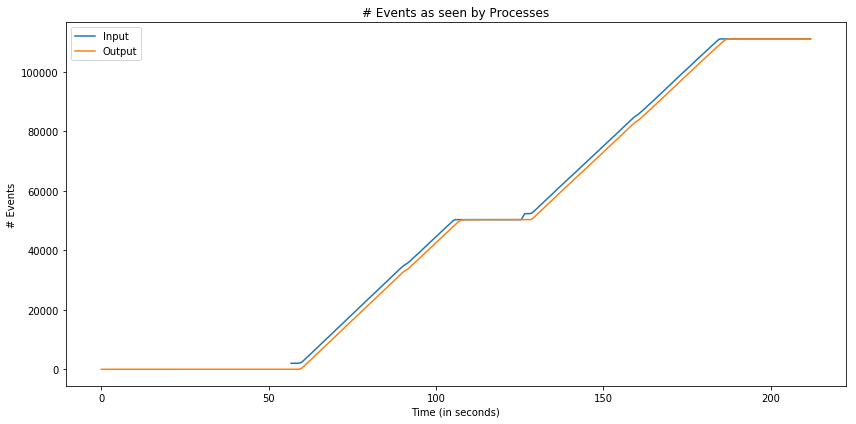

In [16]:
plt.figure(figsize=(12, 6))

df["tcp://hltin:7000"]["output"]["sent_events"].plot(label="Input")
df["tcp://hltout:7000"]["input"]["received_events"].plot(label="Output")

plt.legend(frameon=True)

plt.xlabel("Time (in seconds)")
plt.ylabel("# Events")
plt.title("# Events as seen by Processes")
plt.tight_layout()

As expected, the events grow quite steadily with a distance between input and output process (as they need to be reconstructed). When stopping, this difference is decreasing until it is 0.

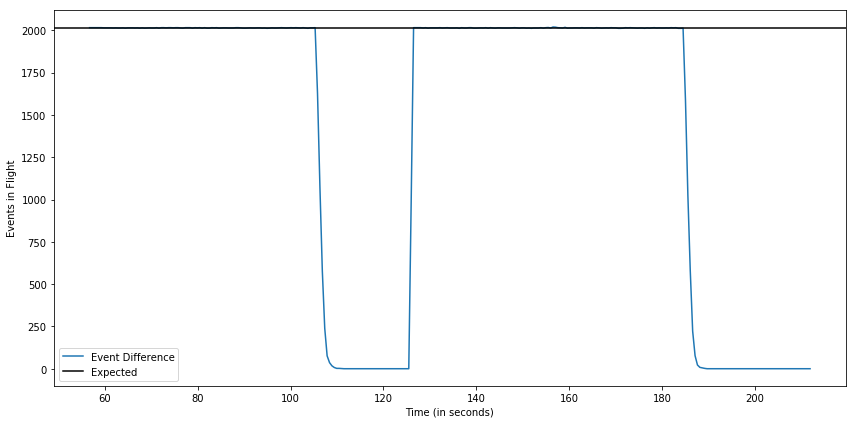

In [21]:
plt.figure(figsize=(12, 6))

(df["tcp://hltin:7000"]["output"]["sent_events"] - df["tcp://hltout:7000"]["input"]["received_events"]).plot(label="Event Difference")
plt.gca().axhline(56*3*12, color="black", label="Expected")

plt.legend(frameon=True)

plt.xlabel("Time (in seconds)")
plt.ylabel("Events in Flight")
plt.tight_layout()

This plot is a slightly changed version of the above only showing the difference between input and output.
The expected number is 
    
    (number of workers) * (2 + 1)
    
as 2 is the buffer size and 1 event is currently being reprocessed. This expectation is very good reached.
When stopping, the number really falls to 0 - so all events that were send also make it to the output.

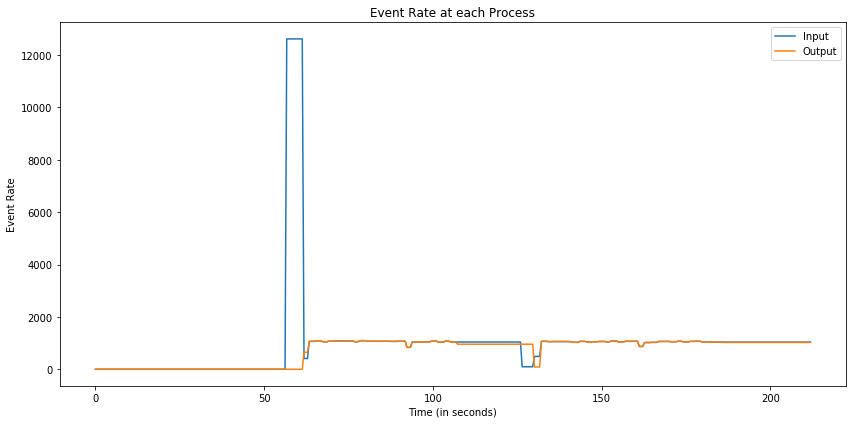

In [13]:
plt.figure(figsize=(12, 6))

df["tcp://hltin:7000"]["output"]["event_rate"].plot(label="Input")
df["tcp://hltout:7000"]["input"]["event_rate"].plot(label="Output")

plt.legend(frameon=True)

plt.xlabel("Time (in seconds)")
plt.ylabel("Event Rate")
plt.title("Event Rate at each Process")
plt.tight_layout()

The event rate at the input process is very high in the beginning until all queues are full (queue size is 2 in this case). Then, it falls to ~ 1kHz (as expected) for output and input. When stopped, the event rate is 0.

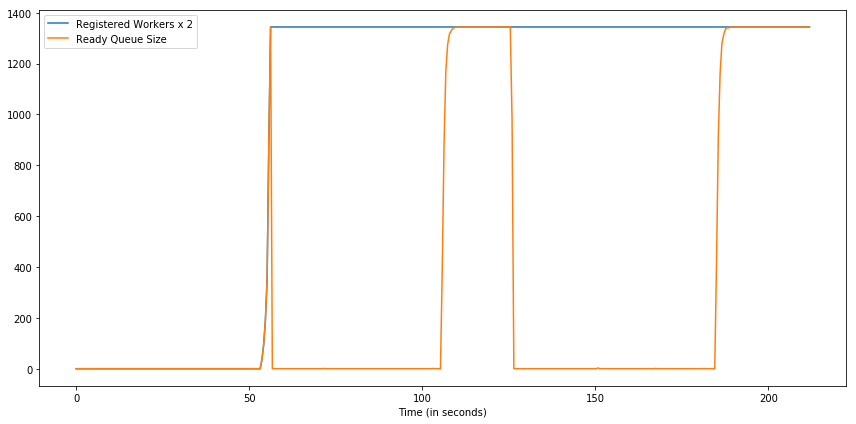

In [12]:
plt.figure(figsize=(12, 6))

(2 * df["tcp://hltin:7000"]["output"]["registered_workers"]).plot(label="Registered Workers x 2")
df["tcp://hltin:7000"]["output"]["ready_queue_size"].plot(label="Ready Queue Size")

plt.legend(frameon=True)

plt.xlabel("Time (in seconds)")
plt.tight_layout()

This plot shows how many workers are registered at the input process and how many ready messages are currently there. In the beginning, every worker sends 2 ready messages (setting of buffer size) - that is why for better comparison the number of registered workers is also multiplied by 2 in the picture.

When the processing starts, the ready queue size drops to 0 (but is not always 0 of course), which is good as it shows that the input process can feed events quickly enough.
When stopping, the ready queue size starts to build up again.

## Stopping Behaviour (Normal Processing)

In [97]:
df = load_measurement_file("studies/meas_7/output_full.dat")

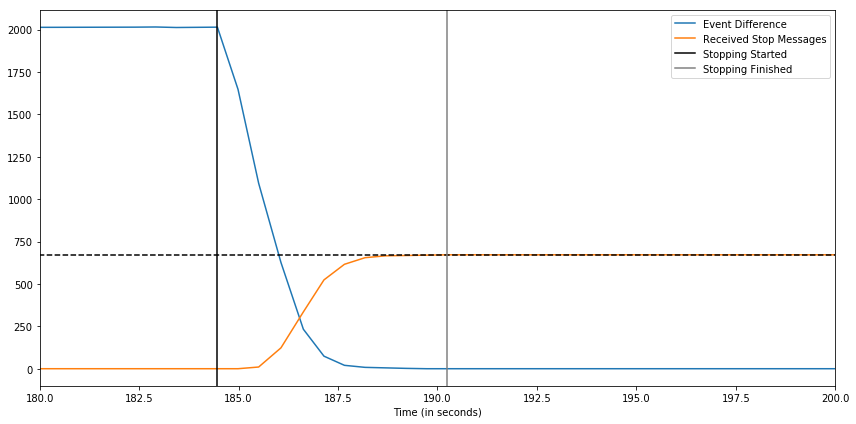

In [98]:
plt.figure(figsize=(12, 6))

(df["tcp://hltin:7000"]["output"]["sent_events"] - df["tcp://hltout:7000"]["input"]["received_events"]).plot(label="Event Difference")

df["tcp://hltout:7000"]["input"]["received_stop_messages"].plot(label="Received Stop Messages")
df["tcp://hltout:7000"]["input"]["registered_workers"].plot(label="_no_label", color="black", ls="--")

cond_stopping_start = (df["tcp://hltin:7000"]["output"]["sent_events"] - df["tcp://hltout:7000"]["input"]["received_events"]) > 1900
time_stopping_start = df[cond_stopping_start].iloc[-1].name 
cond_stopping_stop = (df["tcp://hltout:7000"]["input"]["all_stop_messages"] == 1) & (df.index > 150)
time_stopping_stop = df[cond_stopping_stop].iloc[0].name

plt.gca().axvline(time_stopping_start, color="black", label="Stopping Started")
plt.gca().axvline(time_stopping_stop, color="gray", label="Stopping Finished")

plt.xlim(180, 200)
plt.xlabel("Time (in seconds)")

plt.legend(frameon=True)

plt.tight_layout()

This will be a bit compicated plot, so lets build it up step by step. The plot only shows the stopping behaviour of a normal run.
* the event difference is again the difference between input and output, which is high during running and drops to 0 after stopping.
* the first vertical bar shows the time when the stopping started
* the collector receives a stop message from every registered workers when it is done with all events. This will not happen all at the same time, because reconstruction time is not always the same. So it builds up slowely.
* at some point, all stop messages are received and the stop is finished.

In total, it costed around 5s to stop (without histogram, see next plot).

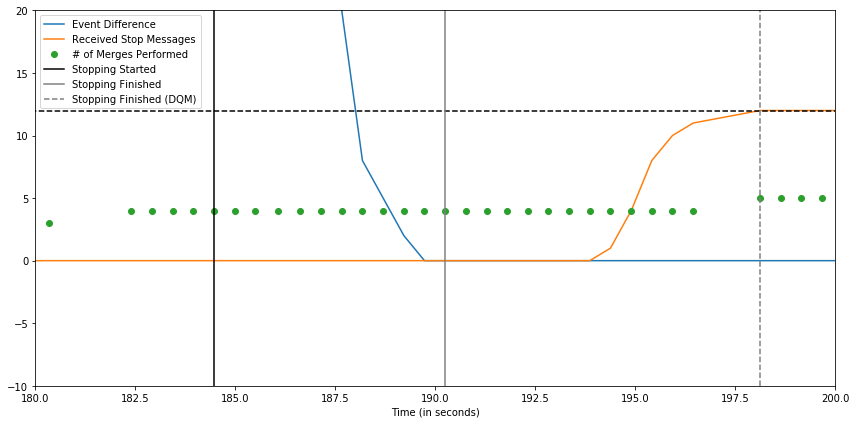

In [99]:
plt.figure(figsize=(12, 6))

((df["tcp://hltin:7000"]["output"]["sent_events"] - df["tcp://hltout:7000"]["input"]["received_events"])).plot(label="Event Difference")

df["tcp://hltctl:7000"]["input"]["received_stop_messages"].plot(label="Received Stop Messages")
df["tcp://hltctl:7000"]["input"]["registered_workers"].plot(label="_no_label", color="black", ls="--")

cond_stopping_start = (df["tcp://hltin:7000"]["output"]["sent_events"] - df["tcp://hltout:7000"]["input"]["received_events"]) > 1900
time_stopping_start = df[cond_stopping_start].iloc[-1].name 
cond_stopping_stop = (df["tcp://hltout:7000"]["input"]["all_stop_messages"] == 1) & (df.index > 150)
time_stopping_stop = df[cond_stopping_stop].iloc[0].name

cond_stopping_stop_hist = (df["tcp://hltctl:7000"]["input"]["all_stop_messages"] == 1) & (df.index > 150)
time_stopping_stop_hist = df[cond_stopping_stop_hist].iloc[0].name

df["tcp://hltctl:7000"]["output"]["histogram_merges"].plot(ls="", marker="o", label="# of Merges Performed")

plt.gca().axvline(time_stopping_start, color="black", label="Stopping Started")
plt.gca().axvline(time_stopping_stop, color="gray", label="Stopping Finished")
plt.gca().axvline(time_stopping_stop_hist, color="gray", label="Stopping Finished (DQM)", ls="--")

plt.xlim(180, 200)
plt.ylim(-10, 20)
plt.xlabel("Time (in seconds)")

plt.legend(frameon=True)

plt.tight_layout()

This plot is the same as before (zoomed in), however the number of receives stop messages is not not taken from the collector, but from the final histogram server.
On run stop, all workers send out their histograms to the local DQM server, which merges them and then sends them out to the final histogram server, which also merges them.
As expected, this merging process needs some time (around 10s), so the stopping of the DQM is delayed behind the collector stopping.
Still, the total stopping time between the distributor sendout out the last event and the collector as well as the DQM having recieved all events is below 15s.

(if you wonder: there are 12 HLT workers, so 12 local DQM servers, that is why the final DQM server has 12 clients and receives 12 stop messages)

The shown number of performed merges of the histogram server also shows, that on stop a final merge mas actually performed including all the histograms received. It is also interesting to see that there is a missing data point, as the histogram server was doing the merge, it could not react to the monitoring request, so the data point is missing.

## Stopping Behaviour (when killing)

In [79]:
df = load_measurement_file("studies/meas_8/output_kill_workers_full.dat")

This measurement was done similar to the one above. However, during running, two workers were killed on purpose (externally). The restart feature was enabled, so the workers were replaced by the framework and the processing continued.

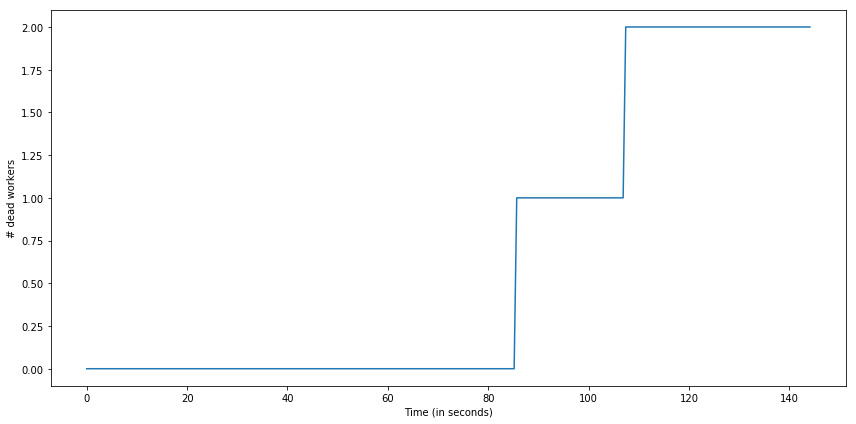

In [91]:
plt.figure(figsize=(12, 6))

df["tcp://hltout:7000"]["input"]["dead_workers"].plot()

plt.xlabel("Time (in seconds)")
plt.ylabel("# dead workers")

plt.tight_layout()

The killing of workers can be seen in this plot.

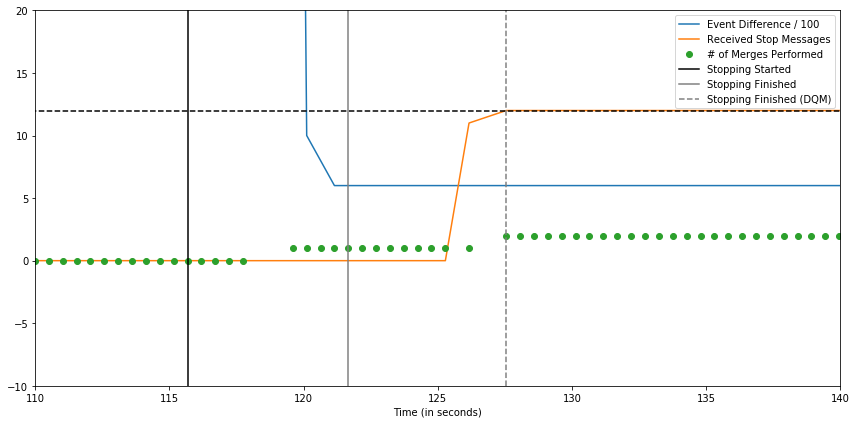

In [94]:
plt.figure(figsize=(12, 6))

((df["tcp://hltin:7000"]["output"]["sent_events"] - df["tcp://hltout:7000"]["input"]["received_events"])).plot(label="Event Difference / 100")

df["tcp://hltctl:7000"]["input"]["received_stop_messages"].plot(label="Received Stop Messages")
df["tcp://hltctl:7000"]["input"]["registered_workers"].plot(label="_no_label", color="black", ls="--")

cond_stopping_start = (df["tcp://hltin:7000"]["output"]["sent_events"] - df["tcp://hltout:7000"]["input"]["received_events"]) > 1900
time_stopping_start = df[cond_stopping_start].iloc[-1].name 
cond_stopping_stop = (df["tcp://hltout:7000"]["input"]["all_stop_messages"] == 1) 
time_stopping_stop = df[cond_stopping_stop].iloc[0].name

cond_stopping_stop_hist = (df["tcp://hltctl:7000"]["input"]["all_stop_messages"] == 1)
time_stopping_stop_hist = df[cond_stopping_stop_hist].iloc[0].name

df["tcp://hltctl:7000"]["output"]["histogram_merges"].plot(ls="", marker="o", label="# of Merges Performed")

plt.gca().axvline(time_stopping_start, color="black", label="Stopping Started")
plt.gca().axvline(time_stopping_stop, color="gray", label="Stopping Finished")
plt.gca().axvline(time_stopping_stop_hist, color="gray", label="Stopping Finished (DQM)", ls="--")

plt.xlim(110, 140)
plt.ylim(-10, 20)
plt.xlabel("Time (in seconds)")

plt.legend(frameon=True)

plt.tight_layout()

The plot shows again the stopping behaviour with the DQM. Although workers were missing, the stopping still works as expected in ~15 s and with all stop messages received both in the DQM server as well as the collector (not shown, but the vertical bar corresponds to this).
As expected, some events are missing in the collector, as the workers have died:

    (killed workers) x (queue size + one event in flight) = 2 x (2 + 1) = 6
    
This is also visible in the plot.

(also note that by accident, a periodical merge of the DQM histograms has happened right before the stop, which was no problem).

In [101]:
df = load_measurement_file("studies/meas_6/output_kill_workers_full.dat")

This measurement has the same setup as the one before, however in this case the automatic deregistration of the worker did now work properly. Still, everything was smooth:

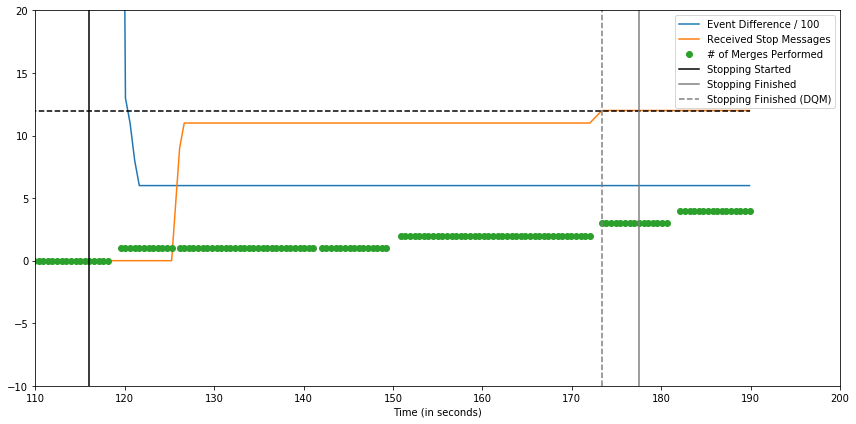

In [105]:
plt.figure(figsize=(12, 6))

((df["tcp://hltin:7000"]["output"]["sent_events"] - df["tcp://hltout:7000"]["input"]["received_events"])).plot(label="Event Difference / 100")

df["tcp://hltctl:7000"]["input"]["received_stop_messages"].plot(label="Received Stop Messages")
df["tcp://hltctl:7000"]["input"]["registered_workers"].plot(label="_no_label", color="black", ls="--")

cond_stopping_start = (df["tcp://hltin:7000"]["output"]["sent_events"] - df["tcp://hltout:7000"]["input"]["received_events"]) > 1900
time_stopping_start = df[cond_stopping_start].iloc[-1].name 
cond_stopping_stop = (df["tcp://hltout:7000"]["input"]["all_stop_messages"] == 1) 
time_stopping_stop = df[cond_stopping_stop].iloc[0].name

cond_stopping_stop_hist = (df["tcp://hltctl:7000"]["input"]["all_stop_messages"] == 1)
time_stopping_stop_hist = df[cond_stopping_stop_hist].iloc[0].name

df["tcp://hltctl:7000"]["output"]["histogram_merges"].plot(ls="", marker="o", label="# of Merges Performed")

plt.gca().axvline(time_stopping_start, color="black", label="Stopping Started")
plt.gca().axvline(time_stopping_stop, color="gray", label="Stopping Finished")
plt.gca().axvline(time_stopping_stop_hist, color="gray", label="Stopping Finished (DQM)", ls="--")

plt.xlim(110, 200)
plt.ylim(-10, 20)
plt.xlabel("Time (in seconds)")

plt.legend(frameon=True)

plt.tight_layout()

As the deregistration did not work properly, the DQM and collector were still waiting for a stop message by one of the died workers. They would wait for ever, as this worker will not send out a stop message (as it is killed).
However, there is a timeout for a "stop-overwrite" after 50s, which still makes the processes go to stopped as expected without the need to abort the run. Also note the the periodic DQM merging.